<a href="https://colab.research.google.com/github/tejas5t6/project-using-cnn/blob/main/Copy_of_Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INSTALLING THE LIBRARY**



In [19]:
!pip install tensorflow tensorflow-datasets gradio --quiet

**IMPORTING THE FILES**

In [20]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import gradio as gr
import os
from google.colab import drive


**MOUNTING THE DRIVE**

In [21]:
drive.mount('/content/drive')
model_path = "/content/drive/MyDrive/cat_dog_mobilenetv2_model.h5"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 **Preprocessing for MobileNetV2 + Binary Label Conversion**

In [22]:

def preprocess_binary(image, label):
    is_dog = tf.cast(label >= 12, tf.int64)  # Labels ≥ 12 are dogs
    image = tf.image.resize(image, (180, 180))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, is_dog

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


In [23]:
(train_ds, val_ds), info = tfds.load(
    'oxford_iiit_pet',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

train_ds = train_ds.map(preprocess_binary).shuffle(1000).batch(32).prefetch(1)
val_ds = val_ds.map(preprocess_binary).batch(32).prefetch(1)


**TRAINING THE MODEL IF NOT TRAINED**

In [24]:
if not os.path.exists(model_path):
    print("🔧 Training new model...")

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(180, 180, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze the base

    model = tf.keras.Sequential([
        data_augmentation,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds, validation_data=val_ds, epochs=5)

    model.save(model_path)
    print("✅ Model trained and saved.")
else:
    print("📁 Loading model from Drive...")
    model = tf.keras.models.load_model(model_path)
    print("✅ Model loaded.")
    history = None  # No training history when loading


🔧 Training new model...


/tmp/ipython-input-4015750266.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.7479 - loss: 0.5523 - val_accuracy: 0.8546 - val_loss: 0.3091
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.9005 - loss: 0.2436 - val_accuracy: 0.8981 - val_loss: 0.2496
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.9190 - loss: 0.1961 - val_accuracy: 0.8899 - val_loss: 0.2495
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.9249 - loss: 0.1857 - val_accuracy: 0.8913 - val_loss: 0.2528
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.9282 - loss: 0.1642 - val_accuracy: 0.9144 - val_loss: 0.2139


✅ Model trained and saved.


**ACCURACY AND LOSS CURVE**

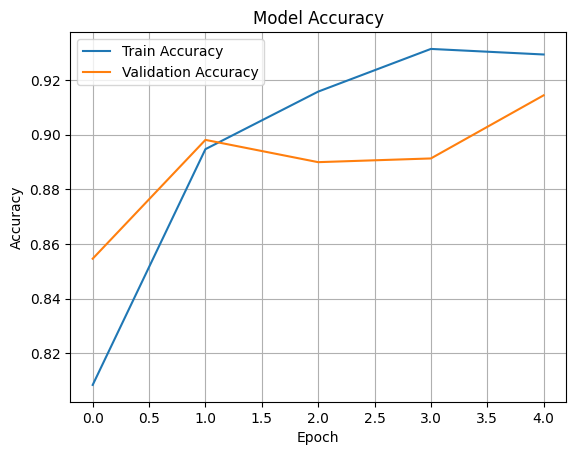

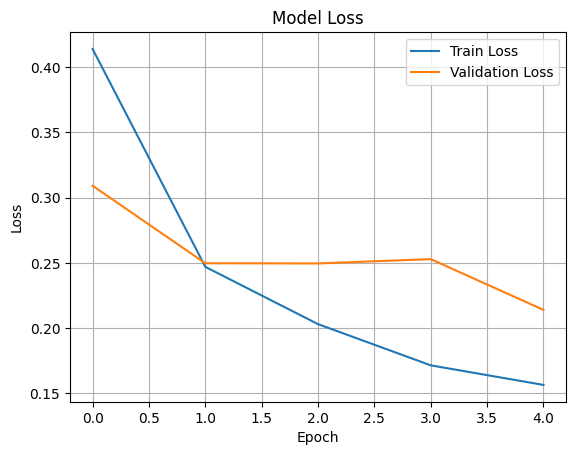

In [25]:
if history:
    # Accuracy Plot
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss Plot
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


**DISPLAY FUNCTION WITH INTEGRATED GRADIO **

In [26]:
def classify_image(image):
    img = image.resize((180, 180))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    img_array = tf.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)[0][0]
    confidence = float(pred) if pred >= 0.5 else 1 - float(pred)
    confidence = round(confidence, 2)

    if confidence < 0.7:
        return {"Unknown / Not Cat or Dog": 1.0}

    label = "Dog" if pred >= 0.5 else "Cat"
    return {
        label: confidence,
        "Cat" if label == "Dog" else "Dog": 1 - confidence
    }

gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    title="🐾 Cat vs Dog Classifier",
    description="Upload an image to classify as Cat or Dog using MobileNetV2 + Data Augmentation"
).launch()



It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1dadac966d95113c53.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
